In [1]:
import os
import pickle
%matplotlib inline
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
nodes = pd.read_csv('../data/nodes_condesed.csv')
edges = pd.read_csv('../data/edges_condesed.csv')

# remove : character from column names to make them queryable
nodes = nodes.rename(columns={':ID': 'ID', ':LABEL': 'LABEL'})
edges = edges.rename(columns={':START_ID': 'START_ID', ':END_ID': 'END_ID', ':TYPE': 'TYPE'})

In [3]:
comps = (nodes['LABEL'] == 'Chemicals & Drugs').sum() 
diseases = (nodes['LABEL'] == 'Disorders').sum()

print('{:,} Compounds x {:,} Diseases = {:,} C-D pairs'.format(comps, diseases, comps*diseases))

98,547 Compounds x 43,228 Diseases = 4,259,989,716 C-D pairs


In [4]:
nodes.head()

,ID,name,LABEL
0,C0038195,State Medicine,Activities & Behaviors
1,C0233512,Normal behavior,Activities & Behaviors
2,C0680431,Apartheid,Activities & Behaviors
3,C0037400,Social Change,Activities & Behaviors
4,C0078912,Aikido,Activities & Behaviors


In [5]:
edges.head()

,START_ID,END_ID,TYPE,pmids
0,C1273870,C0282623,ADMINISTERED_TO_ABatAB,1
1,C0556656,C0221192,ADMINISTERED_TO_ABatCI,7
2,C0035028,C0221192,ADMINISTERED_TO_ABatCI,2
3,C0935546,C0221192,ADMINISTERED_TO_ABatCI,1
4,C1273870,C1138603,ADMINISTERED_TO_ABatCI,2


In [6]:
print(edges.shape[0])
edges = edges.drop_duplicates()
edges = edges.dropna()
edges.shape

18018643


(18018643, 4)

In [7]:
counts = edges["TYPE"].value_counts()
counts

ASSOCIATED_WITH_CDawCD           1415748
LOCATION_OF_AloCD                1229901
INTERACTS_WITH_CDiwG              732705
ASSOCIATED_WITH_DOawDO            712286
TREATS_CDtDO                      634946
CAUSES_LBcDO                      615066
ASSOCIATED_WITH_CDawDO            613957
LOCATION_OF_AloG                  566189
LOCATION_OF_AloDO                 563006
PRODUCES_LBpdCD                   525948
STIMULATES_CDst>CD                512811
TREATS_PRtDO                      446603
INHIBITS_CDinCD                   439092
AUGMENTS_CDagDO                   414322
STIMULATES_CDstG                  386302
AFFECTS_CDafPS                    367386
AFFECTS_CDafA                     336482
ASSOCIATED_WITH_GawDO             327017
PART_OF_GpoLB                     326167
AUGMENTS_DOag>DO                  303738
USES_PRuCD                        293601
LOCATION_OF_AloA                  274594
AFFECTS_GafPS                     262443
INTERACTS_WITH_GiwG               248477
INHIBITS_CDinG  

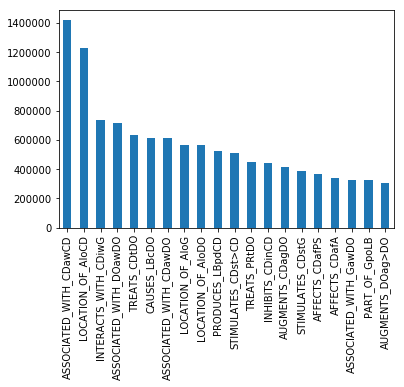

In [8]:
counts[:20].plot(kind='bar');

Several relationships with low counts, A->B and B->A relationships could potentially be combined into A-B relationships

# Filter out the lower count edge types

In [9]:
'{:,}'.format(edges.shape[0])

'18,018,643'

In [10]:
cutoff = .001

print("Number of edge types with this cutoff: {}".format((counts > cutoff*len(edges)).sum()))
print("Number of edges that remain with this cutoff: {:,}".format(counts[counts > cutoff*len(edges)].sum()))

Number of edge types with this cutoff: 75
Number of edges that remain with this cutoff: 16,982,049


In [11]:
ok_edges = list(counts[counts > cutoff*len(edges)].index)

In [12]:
result = edges.query('TYPE in @ok_edges')

In [13]:
'{:,}'.format(result.shape[0])

'16,982,049'

# Some quick validation that all ids are the same between nodes and edges

In [14]:
edge_ids = set(result['START_ID'].unique()).union(set(result['END_ID'].unique()))

In [15]:
node_ids = set(nodes['ID'].unique())

In [16]:
not_in_edges = node_ids - edge_ids

In [17]:
not_in_edges = list(not_in_edges)

In [18]:
idx = nodes.query('ID in @not_in_edges').index
nodes.loc[idx]

,ID,name,LABEL
0,C0038195,State Medicine,Activities & Behaviors
1,C0233512,Normal behavior,Activities & Behaviors
2,C0680431,Apartheid,Activities & Behaviors
3,C0037400,Social Change,Activities & Behaviors
4,C0078912,Aikido,Activities & Behaviors
5,C0680718,arraignment,Activities & Behaviors
6,C0282352,National Security,Activities & Behaviors
7,C0024818,Marital Relationship,Activities & Behaviors
11,C0871808,Management Methods,Activities & Behaviors
12,C1521911,NCI Unconventional Innovations Program,Activities & Behaviors


In [19]:
nodes = nodes.drop(idx)

In [20]:
len(nodes)

258184

In [21]:
# Sort values before writing to disk
result = result.sort_values('TYPE')
nodes = nodes.sort_values('LABEL')

# Add in colons required by neo4j
nodes = nodes.rename(columns={'ID': ':ID', 'LABEL': ':LABEL'})
edges = edges.rename(columns={'START_ID': ':START_ID', 'END_ID': ':END_ID', 'TYPE': ':TYPE'})

result.to_csv('../data/edges_condensed_filtered_001.csv', index=False)
nodes.to_csv('../data/nodes_condensed_filtered_001.csv', index=False)

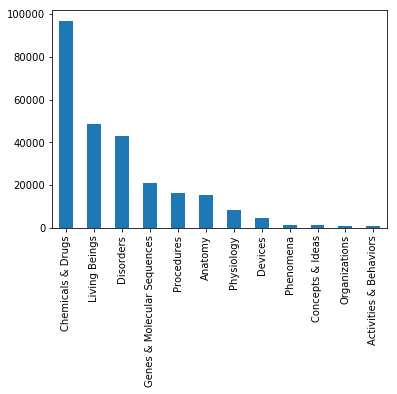

In [23]:
nodes[':LABEL'].value_counts().plot(kind='bar');

# Do some EDA

In [24]:
nodes = nodes.rename(columns={':ID': 'ID', ':LABEL': 'LABEL'})
result = result.rename(columns={':START_ID': 'START_ID', ':END_ID': 'END_ID', ':TYPE': 'TYPE'})

In [25]:
id_to_label = nodes.set_index('ID')['LABEL'].to_dict()
id_to_name = nodes.set_index('ID')['name'].to_dict()

In [26]:
result['start_kind'] = result['START_ID'].apply(lambda i: id_to_label[i])
result['end_kind'] = result['END_ID'].apply(lambda i: id_to_label[i])

result['start_name'] = result['START_ID'].apply(lambda i: id_to_name[i])
result['end_name'] = result['END_ID'].apply(lambda i: id_to_name[i])

In [27]:
max_edge = result["pmids"].max()
result.query('pmids == @max_edge')

,START_ID,END_ID,TYPE,pmids,start_kind,end_kind,start_name,end_name
17229621,C0087111,C0030705,TREATS_PRtLB,136117,Procedures,Living Beings,Therapeutic procedure,Patients


In [28]:
frame = pd.DataFrame()
for i in range(10):

    to_plot = result.query('pmids > @i')['TYPE'].value_counts()
    to_plot = to_plot / to_plot.sum()
    frame[i+1] = to_plot

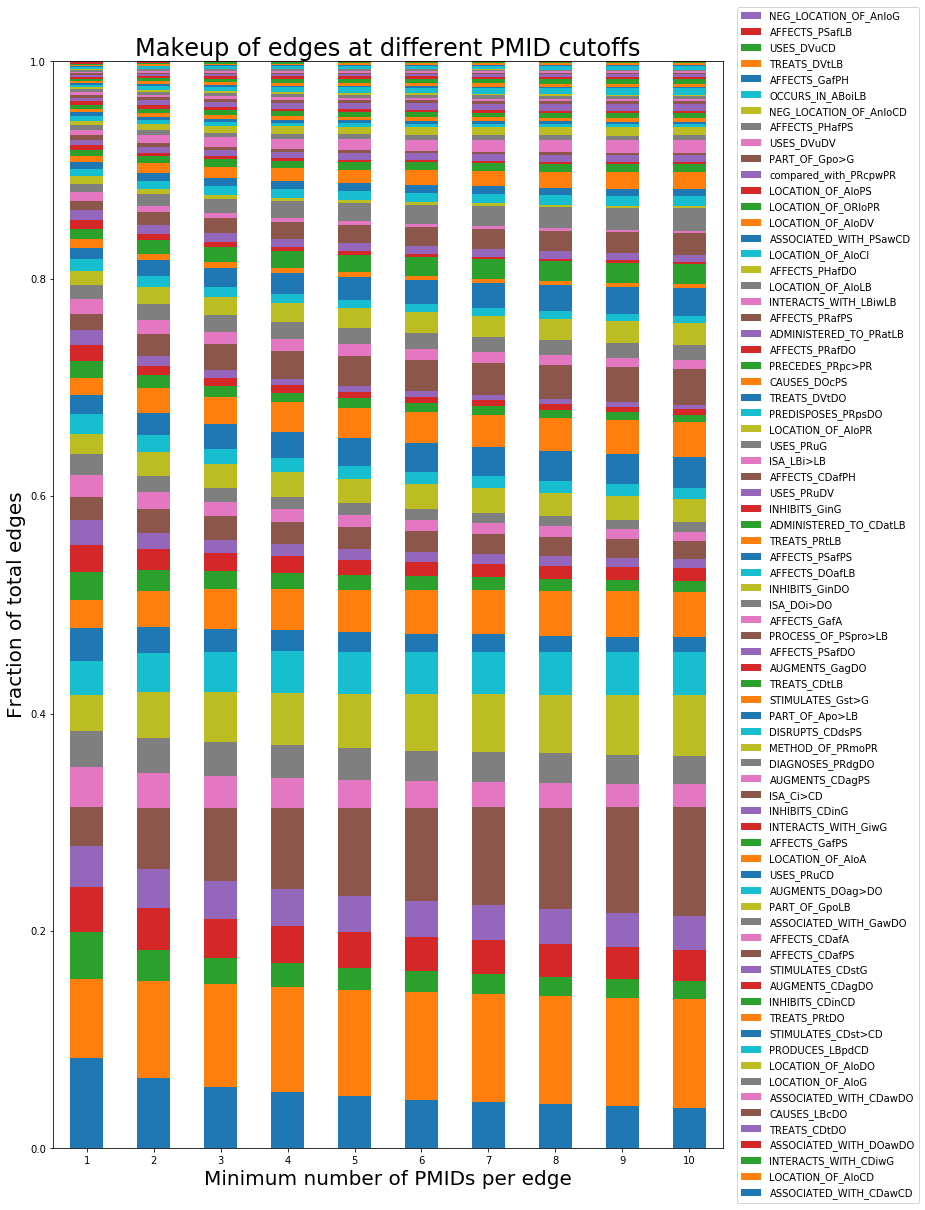

In [35]:
fig = frame.T.plot.bar(stacked=True, figsize=(12, 20))
handels, labels = fig.axes.get_legend_handles_labels()
plt.legend(handels[::-1], labels[::-1], loc=7, bbox_to_anchor=(1.3, 0.5))
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.title('Makeup of edges at different PMID cutoffs', size=24)
plt.xlabel('Minimum number of PMIDs per edge', size=20)
plt.ylabel('Fraction of total edges', size = 20);

In [30]:
result.sort_values('pmids', ascending=False)

,START_ID,END_ID,TYPE,pmids,start_kind,end_kind,start_name,end_name
17229621,C0087111,C0030705,TREATS_PRtLB,136117,Procedures,Living Beings,Therapeutic procedure,Patients
6848905,C0030705,C0012634,CAUSES_LBcDO,92769,Living Beings,Disorders,Patients,Disease
17300050,C0543467,C0030705,TREATS_PRtLB,89997,Procedures,Living Beings,Operative Surgical Procedures,Patients
6848907,C0030705,C1457887,CAUSES_LBcDO,62216,Living Beings,Disorders,Patients,Symptoms
6848908,C0030705,C0006826,CAUSES_LBcDO,57232,Living Beings,Disorders,Patients,Malignant Neoplasms
6848909,C0030705,C0241863,CAUSES_LBcDO,52424,Living Beings,Disorders,Patients,Diabetic
6848910,C0030705,C0009566,CAUSES_LBcDO,50383,Living Beings,Disorders,Patients,Complication
13444296,C0023884,C0034693,PART_OF_Apo>LB,45915,Anatomy,Living Beings,Liver,Rattus norvegicus
13444281,C0006104,C0034693,PART_OF_Apo>LB,45542,Anatomy,Living Beings,Brain,Rattus norvegicus
6848911,C0030705,C0027651,CAUSES_LBcDO,45428,Living Beings,Disorders,Patients,Neoplasm
